# Model_V0

Breakdown of notebook:
1. Create `ImageDataGenerators` for train and validation sets
2. Model architecture
3. Train the model
    - 3.1 Get train images from folder
    - 3.2 Helper-function to train the model
    - 3.3 Helper-function to visualise train and validation loss
    - 3.4 Train the model
4. Test the model (i.e. use for prediction)
    - 4.1 Get test images from folder
    - 4.2 Test the model


---
## Imports

In [1]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow, imsave
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Helper-function to visualise images

In [67]:
# Helper-function for visualising images

def print_RGBimage(RGBimage, img_nchannels, img_height = 'H', img_width = 'W'):
    
    fig, ax = plt.subplots(1, 4, figsize = (16, 4))
    
    # Plotting main image 
    if img_nchannels == 1:
        ax[0].imshow(RGBimage, cmap = plt.cm.gray)
    elif img_nchannels == 3:
        ax[0].imshow(RGBimage)
        
    ax[0].set_title("Original Image")
    ax[0].set_xlabel("W: " + str(img_width))
    ax[0].set_ylabel("H: " + str(img_height))
    ax[0].set_frame_on(False)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    # Plotting RGB channels
    if img_nchannels == 3:
        for i, cmap in enumerate(["Reds", "Greens", "Blues"]):
            ax[i+1].imshow(RGBimage[:, :, i], cmap = cmap)
            ax[i+1].set_title(cmap[0])
            ax[i+1].set_frame_on(False)
            ax[i+1].set_xticks([])
            ax[i+1].set_yticks([])

            
def print_Labimage(Labimage, img_height = 'H', img_width = 'W'):
    
    labimg_rescaled = (Labimage + [0, 128, 128]) / [100, 255, 255]
    
    fig, ax = plt.subplots(1, 4, figsize = (16, 4))
    
    ax[0].imshow(labimg_rescaled)
    ax[0].set_title("Lab Image")
    ax[0].set_xlabel("W: " + str(img_width))
    ax[0].set_ylabel("H: " + str(img_height))
    ax[0].set_frame_on(False)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    for i, col in enumerate(['L', 'a', 'b']):
        
        if col == 'L':
            ax[i+1].imshow(labimg_rescaled[:, :, i], cmap = plt.cm.gray)
        elif col == 'a':
            ax[i+1].imshow(labimg_rescaled[:, :, i], cmap = 'RdYlGn_r')
        elif col == 'b':
            ax[i+1].imshow(labimg_rescaled[:, :, i], cmap = 'YlGnBu_r')
            
        ax[i+1].set_title(col)
        ax[i+1].set_frame_on(False)
        ax[i+1].set_xticks([])
        ax[i+1].set_yticks([])

        
def RGBimage_summary(RGBimage):

    '''Prints a summary of key information of a RGB image and
    prints the image together with is RGB breakdown. RGBimage has
    to be a Numpy array with integers ranging [0, 255].'''
    
    print("=================")
    print("RGB Image Summary")
    print("=================")
    
    RGBimg = RGBimage.astype(int)
    
    img_type = type(RGBimg)
    print(f"Object type: {img_type}")
    
    img_dim = RGBimg.shape
    img_height, img_width = img_dim[0], img_dim[1]
    print(f"Image dimensions: {img_dim}")

    img_nchannels = 1 if len(img_dim) == 2 else img_dim[-1]
    print(f"Number of channels: {img_nchannels}")
    
    if img_nchannels == 3:
        R_max, R_min = np.max(RGBimg[:, :, 0]), np.min(RGBimg[:, :, 0])
        G_max, G_min = np.max(RGBimg[:, :, 1]), np.min(RGBimg[:, :, 1])
        B_max, B_min = np.max(RGBimg[:, :, 2]), np.min(RGBimg[:, :, 2])
        
        print (f"R range: [{R_min}, {R_max}]")
        print (f"G range: [{G_min}, {G_max}]")
        print (f"B range: [{B_min}, {B_max}]")
        
    elif img_nchannels == 1:
        Gray_max, Gray_min = np.max(RGBimg), np.min(RGBimg)
        print(f"Gray range: [{Gray_min}, {Gray_max}]")

    
    # ===== Print image =====
    print_RGBimage(RGBimage = RGBimg, img_nchannels = img_nchannels, img_width = img_width, img_height = img_height)
    

    
def Labimage_summary(Labimage):

    '''Prints a summary of key information of a Lab image and
    prints the image together with is RGB breakdown.'''
    
    print("=================")
    print("Lab Image Summary")
    print("=================")
    
    Labimg = Labimage
    
    img_type = type(Labimg)
    print(f"Object type: {img_type}")
    
    img_dim = Labimg.shape
    img_height, img_width, img_nchannels = img_dim[0], img_dim[1], img_dim[2]
    print(f"Image dimensions: {img_dim}")
    print(f"Number of channels: {img_nchannels}")
    
    L_max, L_min = np.max(Labimg[:, :, 0]), np.min(Labimg[:, :, 0])
    a_max, a_min = np.max(Labimg[:, :, 1]), np.min(Labimg[:, :, 1])
    b_max, b_min = np.max(Labimg[:, :, 2]), np.min(Labimg[:, :, 2])

    print (f"L range: [{L_min}, {L_max}]")
    print (f"a range: [{a_min}, {a_max}]")
    print (f"b range: [{b_min}, {b_max}]")
    
    
    # ===== Print image =====
    print_Labimage(Labimage = Labimg, img_width = img_width, img_height = img_height)

---
## 1. Create `ImageDataGenerators` for train and validation sets

In [2]:
# Create image generator for image augmentation during training
def TrainImage_a_b_gen(Xtrain, batch_size, validation_split):
    '''Function that gets the training images using the flow method
    via train_generator and applies the data augmentation of train_datagen.
    This function is then used in the .fit() method when training the model.
    
    Note that this returns a tuple of (inputs, targets),
    where inputs is a np.array with shape (batch_size, h, w, 1)
    and targets is a np.array with shape (batch_sze, h, w, 2).'''
    
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                       shear_range = 0.4,
                                       zoom_range = 0.4,
                                       rotation_range = 45,
                                       horizontal_flip = True,
                                       validation_split = validation_split)
    
    train_generator = train_datagen.flow(x = Xtrain,
                                         batch_size = batch_size,
                                         subset = "training",
                                         save_to_dir = "Images/PokemonSilver_AugmentedTrain", 
                                         save_prefix = "PokemonSilver_Augmented",
                                         save_format = "png",
                                         shuffle = True,
                                         seed = 42)
    
    # Generate the tuple (X, Y) for each training batch
    for batch in train_generator:
        lab_batch = rgb2lab(batch)
        Xtrain_batch = lab_batch[:, :, :, 0]
        Ytrain_batch = lab_batch[:, :, :, 1:] / 128 # Normalise the values to [-1.0, 1.0]
        yield (Xtrain_batch.reshape(Xtrain_batch.shape + (1, )), Ytrain_batch)
        

def ValidationImage_a_b_gen(Xtrain, batch_size, validation_split):
    
    validation_datagen = ImageDataGenerator(rescale = 1./255,
                                            validation_split = validation_split)
    
    validation_generator = validation_datagen.flow(x = Xtrain,
                                                   batch_size = batch_size,
                                                   subset = "validation",
                                                   save_to_dir = "Images/PokemonSilver_Validation", 
                                                   save_prefix = "PokemonSilver_Validation",
                                                   save_format = "png",
                                                   shuffle = True,
                                                   seed = 42)
    
    # Generate the tuple (X, Y) for each validation batch
    for batch in validation_generator:
        lab_batch = rgb2lab(batch)
        Xval_batch = lab_batch[:, :, :, 0]
        Yval_batch = lab_batch[:, :, :, 1:] / 128
        yield (Xval_batch.reshape(Xval_batch.shape + (1, )), Yval_batch)
        

---
## 2. Model architecture

In [205]:
model = Sequential(name = "Colouring-Pokemon")

model.add(InputLayer(input_shape = (288, 320, 1)))
model.add(Conv2D(name = "Conv2D_8a_3x3", filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same', strides = 2))
model.add(Conv2D(name = "Conv2D_8b_3x3", filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(name = "Conv2D_16a_3x3", filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(name = "Conv2D_16b_3x3", filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same', strides = 2))
model.add(Conv2D(name = "Conv2D_32a_3x3", filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(name = "Conv2D_32b_3x3", filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same', strides = 2))
model.add(UpSampling2D(name = "UpSamp-a_2x2", size = (2, 2)))
model.add(Conv2D(name = "Conv2D_32c_3x3", filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D(name = "UpSamp-b_2x2", size = (2, 2)))
model.add(Conv2D(name = "Conv2D_16c_3x3", filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D(name = "UpSamp-c_2x2", size = (2, 2)))
model.add(Conv2D(name = "Conv2D_2_3x3", filters = 2, kernel_size = (3, 3), activation = 'tanh', padding = 'same'))

In [206]:
model.compile(optimizer = 'rmsprop', loss = 'mse')

---
## 3 Train the model

https://lambdalabs.com/blog/tensorflow-2-0-tutorial-03-saving-checkpoints/

Training logs:

**trainingrun_singleimage**
 - Size of training set = 1
 - Epochs = 1000, EarlyStop at 283
 - Batch size = 1
 - Steps per epoch = 1
 - Validation steps = n/a

**training_run01**
 - Size of training set = approx. 2000
 - Epochs = 10
 - Batch size = 20
 - Steps per epoch = 50
 - Validation steps = 1
 
**training_run02**
 - Size of training set = approx. 6000
 - Epochs = 50
 - Batch size = 20
 - Steps per epoch = 289
 - Validation steps = 1

### 3.1 Get train images from folder

In [5]:
# Get train images from folder
Xtrain = []
Xtrain_dir = Path("Images/PokemonSilver")

# Load image as numpy arrays to the list Xtrain
for filename in os.listdir(Xtrain_dir):
    if not filename.startswith('.'):
        img_dir = Xtrain_dir / filename
        Xtrain.append(img_to_array(load_img(img_dir)))

# Convert the list of arrays into a 4D numpy array
Xtrain = np.array(Xtrain, dtype = float)

In [6]:
print("Xtrain shape:", Xtrain.shape, type(Xtrain))

Xtrain shape: (6433, 288, 320, 3) <class 'numpy.ndarray'>


### 3.2 Helper-function to train the model

In [204]:
def train_and_save_model(training_run, Xtrain, model, validation_split, batch_size, epochs, steps_per_epoch, validation_steps, checkpoint_filepath):
    
    '''Function to train the model and save using ModelCheckpoint and EarlyStopping.'''
    
    print("=============================")
    print(f" ##### TRAINING RUN {training_run} #####")
    print("=============================")
    print()
    print()
    
    # Print model summary
    print("===============")
    print(" MODEL SUMMARY ")
    print("===============")
    print(model.summary())
    print()
    print()
    
    # Print information about training and validation set
    print("===========================")
    print(" TRAIN/VAL DATASET SUMMARY ")
    print("===========================")
    total_train_size = len(Xtrain)
    train_size = round((1 - validation_split) * total_train_size)
    validation_size = round(validation_split * total_train_size)
    print(f"Size of total training set    : {len(Xtrain)}")
    print(f"(Training, validation) split  : ({1 - validation_split}, {validation_split})")
    print(f"Size of training set          : {1 - validation_split} * {total_train_size} = {train_size}")
    print(f"Size of validation set        : {validation_split} * {total_train_size} = {validation_size}")
    print()
    print()
    
    # Checkpoint
    checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                                 monitor = "loss",
                                 mode = "min",
                                 save_best_only = True,
                                 save_weights_only = False,
                                 save_freq = "epoch",
                                 verbose = 2)
    
    # Early Stop
    earlystop = EarlyStopping(monitor = "loss",
                              mode = "min",
                              patience = 100,
                              restore_best_weights = True,
                              verbose = 1)
    
    callbacks_list = [checkpoint, earlystop]
    
    # Train model
    print("=====================================")
    print(" TRAIN, VALIDATE AND SAVE CHECKPOINT")
    print("=====================================")
    model_info = model.fit(x = TrainImage_a_b_gen(Xtrain, batch_size, validation_split),
                           epochs = epochs,
                           steps_per_epoch = steps_per_epoch,
                           validation_data = ValidationImage_a_b_gen(Xtrain, batch_size, validation_split),
                           validation_steps = validation_steps,
                           callbacks = callbacks_list,
                           verbose = 0)
    
    print()
    print()
    print(f"##### END OF TRAINING RUN {training_run} #####")
    
    return model_info



### 3.3 Helper-function to visualise train and validation loss

In [31]:
def plot_TrainValLoss(model_info):
    
    print(model_info.history.keys())
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors_list = ["#000000", "#FF9900"]
    
    i = 0
    for key in model_info.history.keys():
        ax.plot(model_info.history[key], color = colors_list[i], linestyle = "-", label = key)
        i += 1
        
    # Set title
    ax.set_title("Model Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    
    # Hide the right and top spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    
    # Axis stuffs
    ax.set_ylim(bottom = 0)
    ax.set_xlim(xmin = 0)
    
    # Set legend
    ax.legend(loc = "upper left")

### Single Image memorisation trial

In [207]:
# Get SingeImage
singleimage_rgb = img_to_array(load_img('Images/PokemonSilver/PokemonSilver_141.jpg'))
singleimage_lab = rgb2lab((1.0 / 255) * singleimage_rgb)

singleimage_rgb_traininput = singleimage_rgb.reshape(1, 288, 320, 3)

singleimage_lab_predict = singleimage_lab.reshape(1, 288, 320, 3)
singleimage_lab_predict_X = singleimage_lab_predict[:, :, :, 0].reshape(1, 288, 320, 1)
singleimage_lab_predict_Y = singleimage_lab_predict[:, :, :, 1:]

RGB Image Summary
Object type: <class 'numpy.ndarray'>
Image dimensions: (288, 320, 3)
Number of channels: 3
R range: [0, 255]
G range: [0, 255]
B range: [0, 252]
Lab Image Summary
Object type: <class 'numpy.ndarray'>
Image dimensions: (288, 320, 3)
Number of channels: 3
L range: [0.0, 96.96388244628906]
a range: [-69.37649536132812, 88.63145446777344]
b range: [-49.79383850097656, 93.65159606933594]


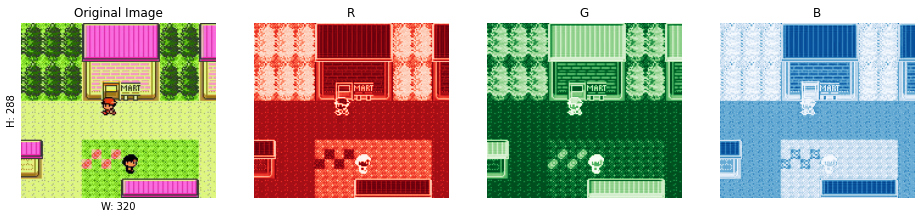

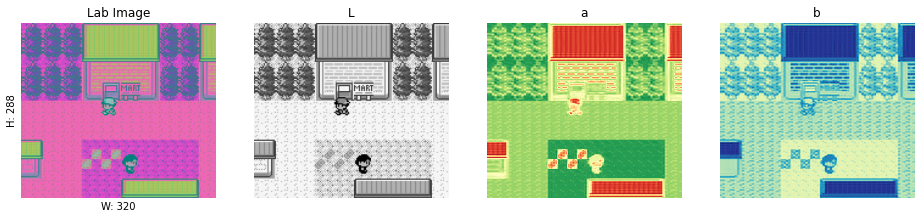

In [208]:
RGBimage_summary(singleimage_rgb)
Labimage_summary(singleimage_lab)

In [209]:
singleimage_info = train_and_save_model(training_run = "Single Image", 
                                        Xtrain = singleimage_rgb_traininput,
                                        model = model,
                                        validation_split = 0,
                                        batch_size = 1,
                                        epochs = 1000,
                                        steps_per_epoch = 1,
                                        validation_steps = 1,
                                        checkpoint_filepath = "SavedCheckpoints/trainingrun_singleimage/model.{epoch:02d}-{val_loss:.6f}.hdf5")

 ##### TRAINING RUN Single Image #####


 MODEL SUMMARY 
Model: "Colouring-Pokemon"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_8a_3x3 (Conv2D)       (None, 144, 160, 8)       80        
_________________________________________________________________
Conv2D_8b_3x3 (Conv2D)       (None, 144, 160, 8)       584       
_________________________________________________________________
Conv2D_16a_3x3 (Conv2D)      (None, 144, 160, 16)      1168      
_________________________________________________________________
Conv2D_16b_3x3 (Conv2D)      (None, 72, 80, 16)        2320      
_________________________________________________________________
Conv2D_32a_3x3 (Conv2D)      (None, 72, 80, 32)        4640      
_________________________________________________________________
Conv2D_32b_3x3 (Conv2D)      (None, 36, 40, 32)        9248      
__________________________________________________________


Epoch 00105: loss did not improve from 0.03218

Epoch 00106: loss did not improve from 0.03218

Epoch 00107: loss did not improve from 0.03218

Epoch 00108: loss did not improve from 0.03218

Epoch 00109: loss did not improve from 0.03218

Epoch 00110: loss did not improve from 0.03218

Epoch 00111: loss did not improve from 0.03218

Epoch 00112: loss did not improve from 0.03218

Epoch 00113: loss did not improve from 0.03218

Epoch 00114: loss did not improve from 0.03218

Epoch 00115: loss did not improve from 0.03218

Epoch 00116: loss did not improve from 0.03218

Epoch 00117: loss did not improve from 0.03218

Epoch 00118: loss did not improve from 0.03218

Epoch 00119: loss did not improve from 0.03218

Epoch 00120: loss did not improve from 0.03218

Epoch 00121: loss did not improve from 0.03218

Epoch 00122: loss did not improve from 0.03218

Epoch 00123: loss did not improve from 0.03218

Epoch 00124: loss did not improve from 0.03218

Epoch 00125: loss did not improve from 


Epoch 00274: loss did not improve from 0.02954

Epoch 00275: loss did not improve from 0.02954

Epoch 00276: loss did not improve from 0.02954

Epoch 00277: loss did not improve from 0.02954

Epoch 00278: loss did not improve from 0.02954

Epoch 00279: loss did not improve from 0.02954

Epoch 00280: loss did not improve from 0.02954

Epoch 00281: loss did not improve from 0.02954

Epoch 00282: loss did not improve from 0.02954

Epoch 00283: loss did not improve from 0.02954
Restoring model weights from the end of the best epoch.
Epoch 00283: early stopping


##### END OF TRAINING RUN Single Image #####


dict_keys(['loss', 'val_loss'])


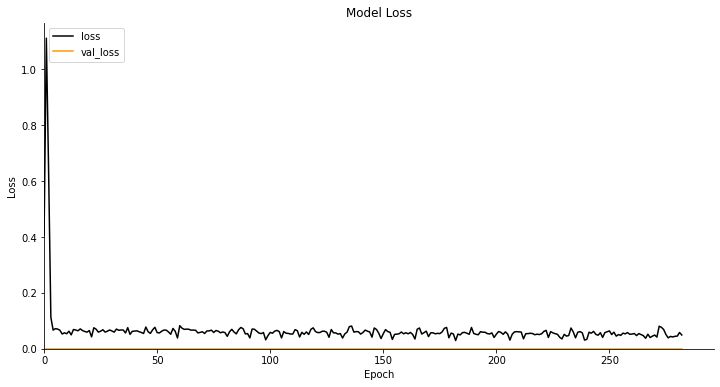

In [210]:
plot_TrainValLoss(singleimage_info)

In [211]:
# Test the model on predicting singleimage
output = model.predict(singleimage_lab_predict_X)
output *= 128

output_array_lab = np.zeros((288, 320, 3))
output_array_lab[:, :, 0] = singleimage_lab_predict_X[0, :, :, 0]
output_array_lab[:, :, 1:] = output[0]
output_array_rgb = lab2rgb(output_array_lab) * 255

/Users/cleonwong/Desktop/Code/python-virtual-environments/Colouring-Pokemon_env/lib/python3.7/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 522 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Lab Image Summary
Object type: <class 'numpy.ndarray'>
Image dimensions: (288, 320, 3)
Number of channels: 3
L range: [0.0, 96.96388244628906]
a range: [-57.57097625732422, 76.07059478759766]
b range: [-30.846126556396484, 87.09014129638672]
RGB Image Summary
Object type: <class 'numpy.ndarray'>
Image dimensions: (288, 320, 3)
Number of channels: 3
R range: [0, 255]
G range: [0, 255]
B range: [0, 227]


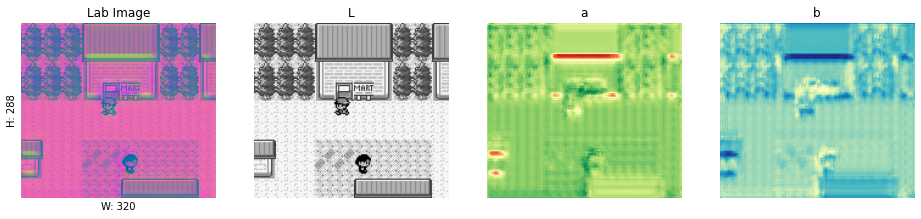

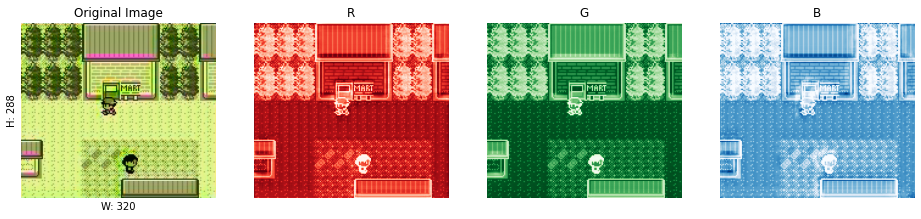

In [212]:
Labimage_summary(output_array_lab)
RGBimage_summary(output_array_rgb)

### 3.4 Train the model

In [17]:
model_info = train_and_save_model(training_run = "Single Image", 
                                  Xtrain = Xtrain,
                                  model = model,
                                  validation_split = 0,
                                  batch_size = 1,
                                  epochs = 10000,
                                  steps_per_epoch = 1,
                                  validation_steps = 1,
                                  checkpoint_filepath = "SavedCheckpoints/trainingrun_singleimage/model.{epoch:02d}-{val_loss:.6f}.hdf5")

 ##### TRAINING RUN 1ImageTest #####


 MODEL SUMMARY 
Model: "Colouring-Pokemon"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_8a_3x3 (Conv2D)       (None, 144, 160, 8)       80        
_________________________________________________________________
Conv2D_8b_3x3 (Conv2D)       (None, 144, 160, 8)       584       
_________________________________________________________________
Conv2D_16a_3x3 (Conv2D)      (None, 144, 160, 16)      1168      
_________________________________________________________________
Conv2D_16b_3x3 (Conv2D)      (None, 72, 80, 16)        2320      
_________________________________________________________________
Conv2D_32a_3x3 (Conv2D)      (None, 72, 80, 32)        4640      
_________________________________________________________________
Conv2D_32b_3x3 (Conv2D)      (None, 36, 40, 32)        9248      
____________________________________________________________

dict_keys(['loss', 'val_loss'])


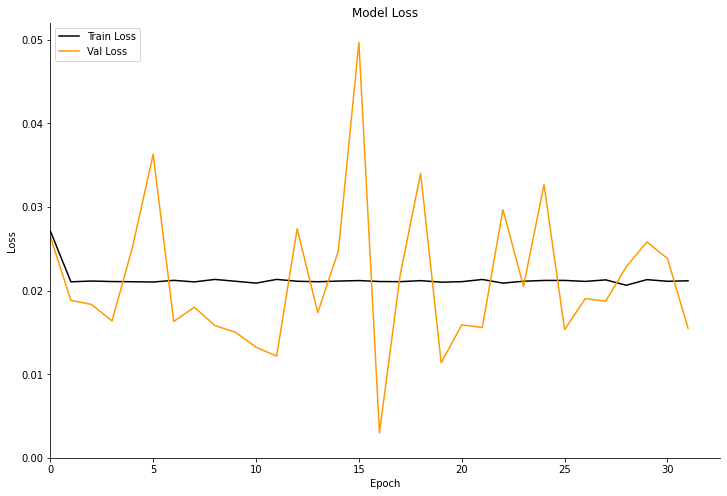

In [10]:
plot_TrainValLoss(model_info)

---
## 4. Test the model (i.e. use for prediction)
### 4.1 Get test images from folder

In [11]:
colourme = []
colourme_dir = Path("Images/PokemonBlue")

# Load image as numpy arrays to the list colourme
for filename in os.listdir(colourme_dir):
    if not filename.startswith('.'):
        img_dir = colourme_dir / filename
        colourme.append(img_to_array(load_img(img_dir)))

colourme = np.array(colourme, dtype = float)
colourme = rgb2lab(1.0/255 * colourme)[:, :, :, 0]
colourme = colourme.reshape(colourme.shape + (1, ))

In [12]:
print("colourme shape:", colourme.shape, type(colourme))

colourme shape: (826, 288, 320, 1) <class 'numpy.ndarray'>


### 4.2 Test the model

In [13]:
# Test the model on colour_me
output = model.predict(colourme)
output *= 128

---
## Save colourised images

In [14]:
# Output colourisations of colour_me
for i in range(len(output)):
    output_array = np.zeros((288, 320, 3))
    output_array[:, :, 0] = colourme[i][:, :, 0]
    output_array[:, :, 1:] = output[i]
    output_array = lab2rgb(output_array)
    output_array = (output_array * 255).astype(np.uint8) # Convert to uint8 to avoid lossy conversion warning
    imsave(f"Outputs_02a/PokemonBlue_predicted{i}.png", output_array)

/Users/cleonwong/Desktop/Code/python-virtual-environments/Colouring-Pokemon_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Outputs_02a/PokemonBlue_predicted49.png is a low contrast image
  
/Users/cleonwong/Desktop/Code/python-virtual-environments/Colouring-Pokemon_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Outputs_02a/PokemonBlue_predicted66.png is a low contrast image
  
/Users/cleonwong/Desktop/Code/python-virtual-environments/Colouring-Pokemon_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Outputs_02a/PokemonBlue_predicted147.png is a low contrast image
  
/Users/cleonwong/Desktop/Code/python-virtual-environments/Colouring-Pokemon_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Outputs_02a/PokemonBlue_predicted148.png is a low contrast image
  
/Users/cleonwong/Desktop/Code/python-virtual-environments/Colouring-Pokemon_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 